# Flat Fielding: An alternative approach

In another notebook, in order to extract the stacked flat spectrum, we first retrieved the flux from each flat files and then stacked them. It turned out that one can do the same procedure in reverse order as well. Hence, in the present notebook, we explore this approach. We first stack each flat frames (just sum them) after bias subtraction. We can later compare if this makes any difference.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from astropy.io import fits
from scipy.optimize import curve_fit as cft
import os
import utils as utl
import order_id as oid

We first make a list of all of the flat files and visualize one of them

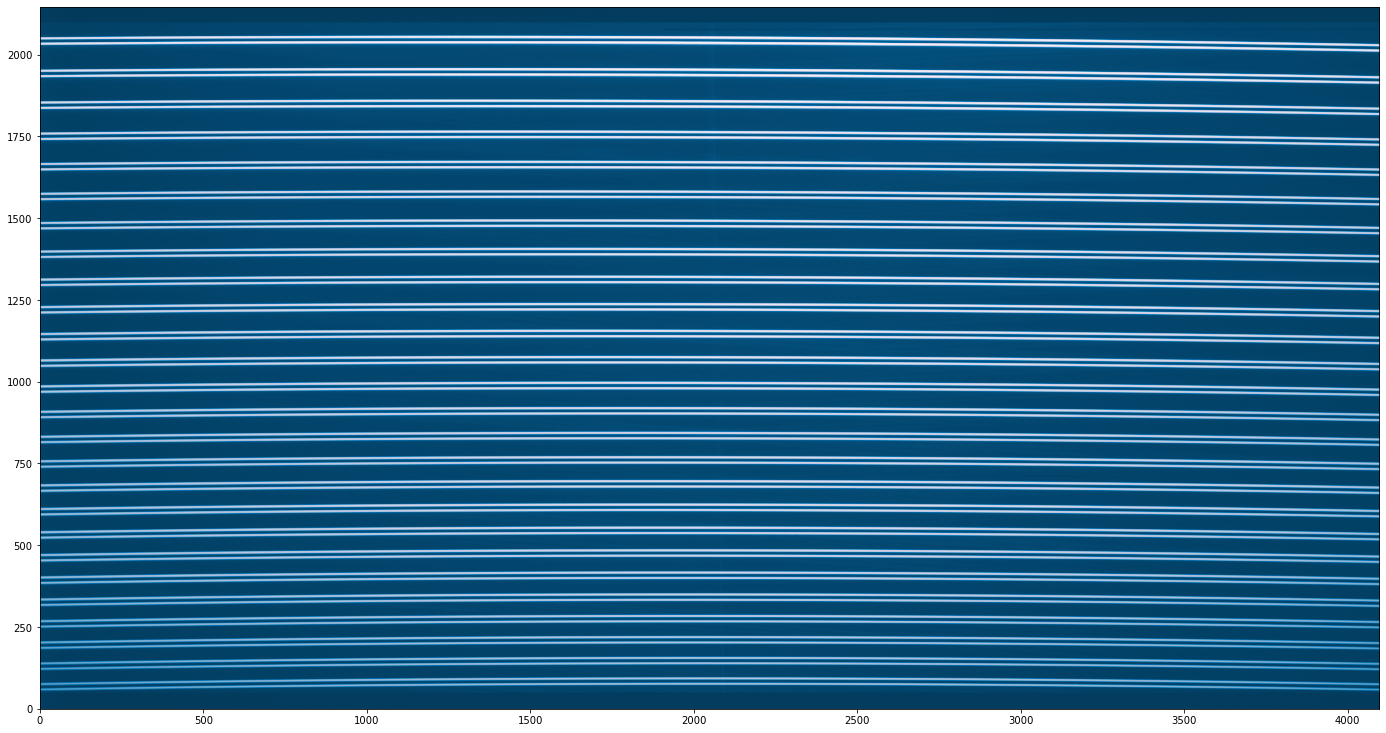

In [2]:
p1 = os.getcwd() + '/Spectro-Module/raw/'
list_all = os.listdir(p1)
list_flat = np.array([])

for i in range(len(list_all)):
    hdul = fits.open(p1 + list_all[i])
    h11 = hdul[0].header
    if h11['HIERARCH ESO DPR TYPE'] == 'LAMP,LAMP,TUN':
        list_flat = np.hstack((list_flat, list_all[i]))

fla1 = fits.open(p1 + list_flat[0])
fla2 = fla1[2].data
fla3 = np.transpose(fla2)
plt.figure(figsize=(16*1.5, 9*1.5))
plt.imshow(fla3, origin='lower', norm=clr.LogNorm(),cmap='PuBu_r')

Now, we want to estimate the bias in each of the files. The method to do this is described in another notebook, hence, we won't be repeat the procedure here. We just make an array of bias in each of the frames (in e-) and another array for read noise in all of the frames (in e-).

In [3]:
bias_n = np.array([])
std_n = np.array([])

for i in range(len(list_flat)):
    hdd = fits.open(p1 + list_flat[i])
    h12 = hdd[2].data
    h13 = np.transpose(h12)
    bias_data = h13[2098:]
    bias_data2 = np.ndarray.flatten(bias_data)
    bias_0 = np.mean(bias_data2)
    bias_n = np.hstack((bias_n, bias_0))
    std_0 = np.std(bias_data2)*1.42
    std_n = np.hstack((std_n, std_0))

std_fin = np.sqrt(np.sum(std_n**2))

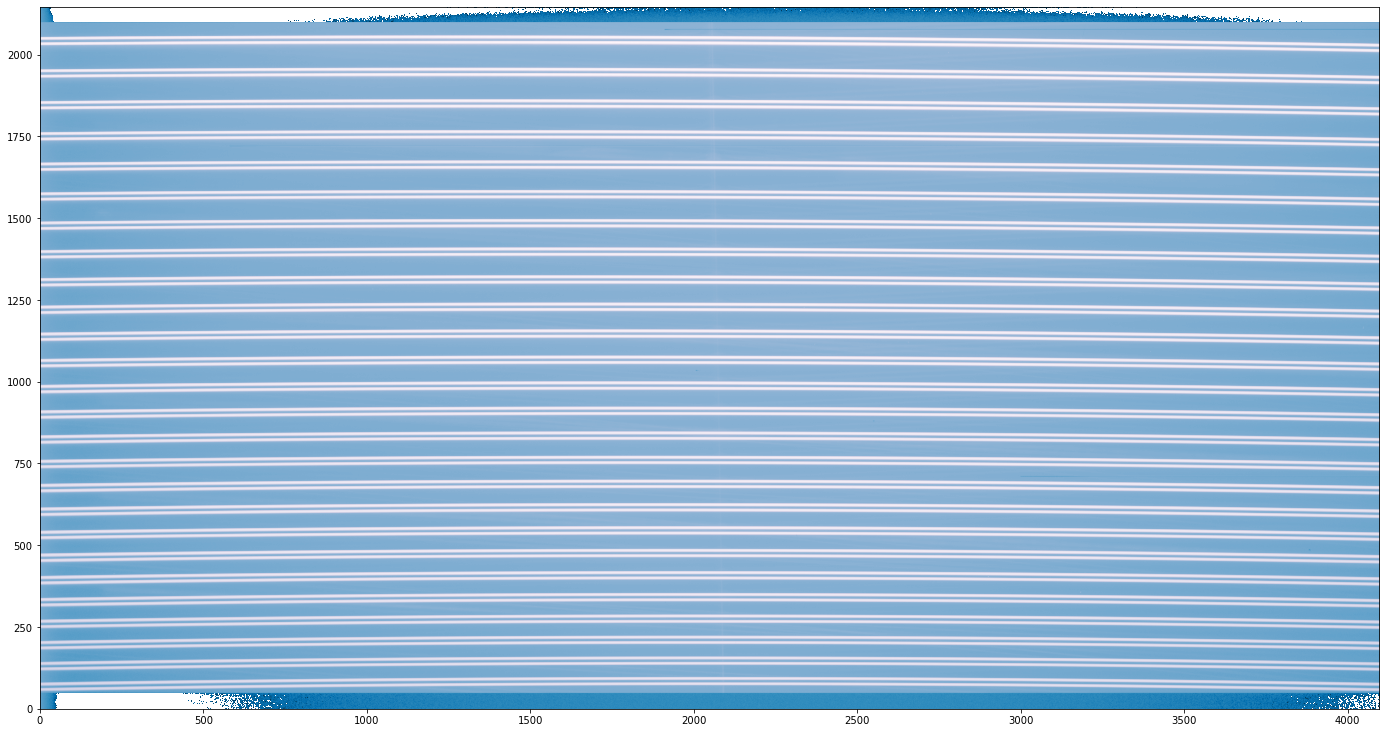

In [4]:
# First frame in e- units
fram0 = (np.copy(fla3) - bias_n[0])*1.42
fram1 = np.copy(fram0)

for j in range(len(list_flat)-1):
    hdd = fits.open(p1 + list_flat[j+1])
    h12 = hdd[2].data
    h13 = np.transpose(h12)
    frm1 = (h13 - bias_n[j+1])*1.42
    fram1 = fram1 + frm1

plt.figure(figsize=(16*1.5, 9*1.5))
plt.imshow(fram1, origin='lower', norm=clr.LogNorm(),cmap='PuBu_r')

## Order Identification

To identify the 104th order, we use the coefficients of the polynomial we used earlier.

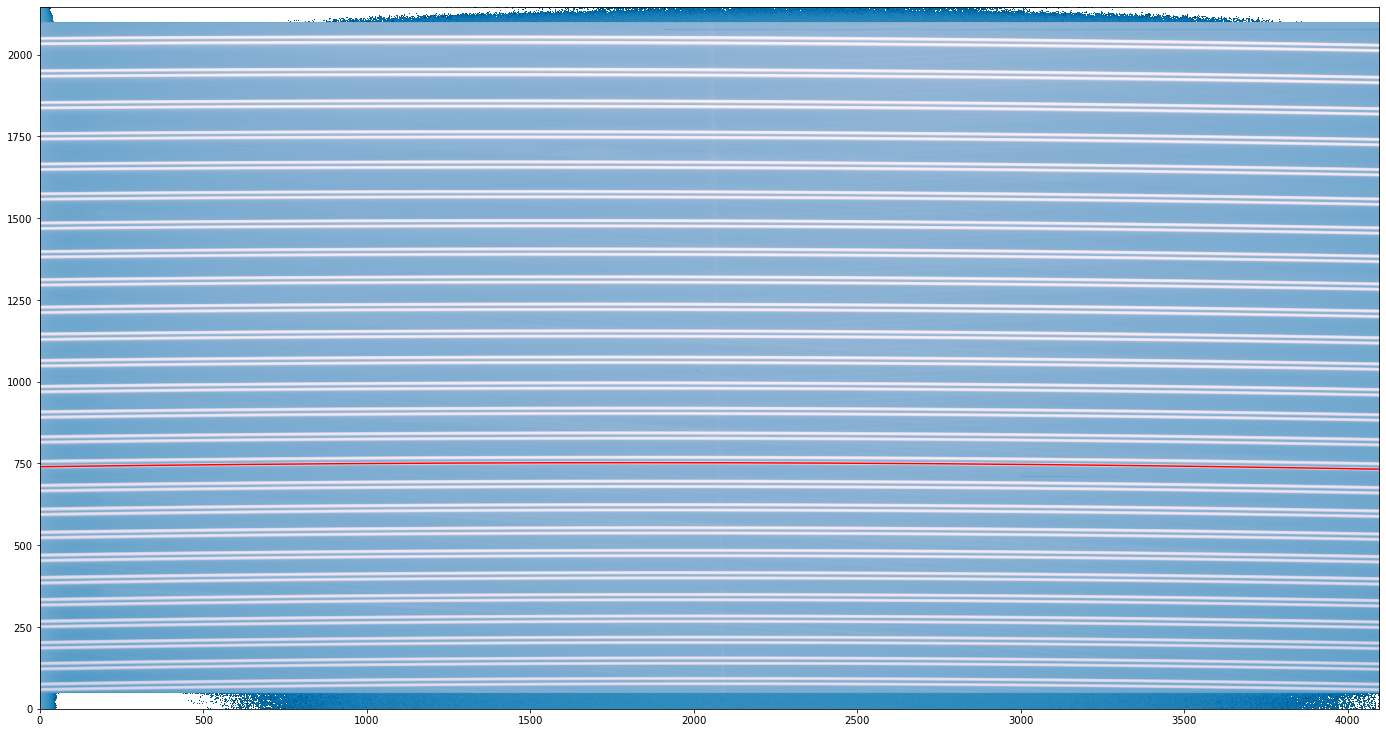

In [5]:
popt1 = np.array([1.49453189e+01, 1.33410596e-02, -3.52806113e-06, -4.42031001e-11])
xdata = np.arange(len(fram1[0]))
ydata = utl.cubic_104(xdata, *popt1)

plt.figure(figsize=(16*1.5, 9*1.5))
plt.imshow(fram1, origin='lower', norm=clr.LogNorm(),cmap='PuBu_r')
plt.plot(xdata, ydata, c='red')

## Flux Extraction

Now, as explained in the other notebook, we just retrieved the number of counts at each pixel in x-direction by just summing up the counts in 7 pixels below and above to the identified order. We also take care in propogating the errors; the read noise was earlier calculated using the overscan region. We further calculate the photon noise for each pixel and add it to the read noise.

In [6]:
flux_flat = np.array([])
flux_err = np.array([])

for i in range(len(ydata)):
    data = fram1[int(ydata[i])-7:int(ydata[i]+7), i]
    flx = np.sum(data)
    flux_flat = np.hstack((flux_flat, flx))
    photon_noise = np.sqrt(flx)
    tot_noise = np.sqrt(photon_noise**2 + std_fin**2)
    flux_err = np.hstack((flux_err, tot_noise))

nor_con = np.max(flux_flat)
flux_nor = flux_flat/nor_con
flux_err_nor = flux_err/nor_con

f1 = open(os.getcwd() + '/Results/flat_alter.dat', 'w')
f1.write('#Pixel\t\t Flux \t\t Err\n')

for i in range(len(xdata)):
    f1.write(str(xdata[i]) + '\t' + str(flux_nor[i]) + '\t' + str(flux_err_nor[i]) + '\n')

f1.close()

Now, let's see how it looks like.

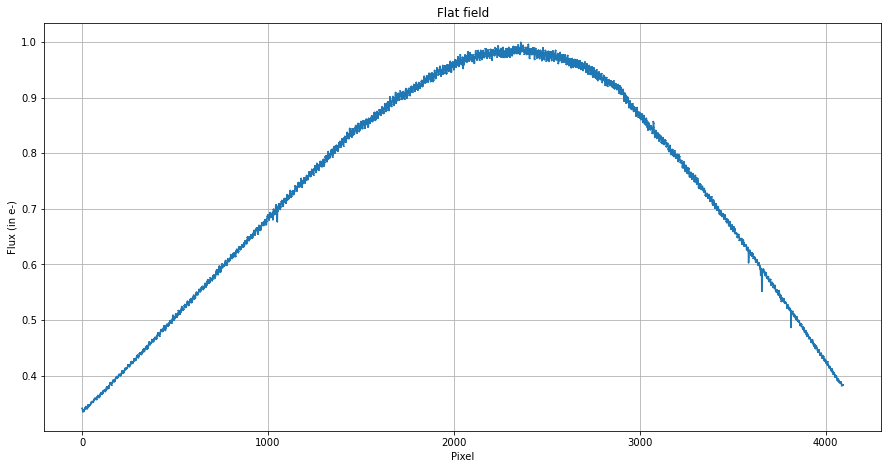

In [7]:
plt.figure(figsize=(15,7.5))
plt.errorbar(xdata, flux_nor, yerr=flux_err_nor)
plt.xlabel('Pixel')
plt.ylabel('Flux (in e-)')
plt.title('Flat field')
plt.grid()